In [1]:
#librerias
import astropy
import warnings
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
from astropy.io import fits
from astropy.visualization import quantity_support
from specutils.spectra import Spectrum1D, SpectralRegion
from specutils.fitting import fit_generic_continuum
from scipy.signal import find_peaks
from scipy.optimize import curve_fit

In [39]:
print("los AGN a estudiar son: , , , , ")
print("1. HB89 0000-263")
print("2. PSS J0121+0347")
print("3. En trabajo")

opcion = int(input("Ingrese la opcion del agujero negro que desea visualizar: "))
if opcion == 1:    
    AGN = "HB89 0000-263"
elif opcion == 2:
    AGN = "PSS J0121+0347"
elif opcion == 3:    
    AGN = ""

# Cargar el archivo FITS con el espectro del AGN (ajusta la ruta según tu archivo)
file_path = AGN+".fits"
datos = fits.open(file_path)

los AGN a estudiar son: , , , , 
1. HB89 0000-263
2. PSS J0121+0347
3. En trabajo
Ingrese la opcion del agujero negro que desea visualizar: 1


In [40]:
#Filtrado y descomposición
wave = datos[1].data

wavelength = wave[0][0] *u.nm
flux = wave[0][1]*u.erg/(u.Angstrom * u.cm * u.cm * u.s)
ERR = wave[0][2]*u.erg/(u.Angstrom * u.cm * u.cm * u.s)
Qual = wave[0][3]
Snr = wave[0][4]
Flux_reduced = wave[0][5]
Err_reduced = wave[0][6]

spectrum = Spectrum1D(spectral_axis=wavelength, flux=flux)
print(wavelength)
print(datos[1])

[ 533.66  533.68  533.7  ... 1019.96 1019.98 1020.  ] nm


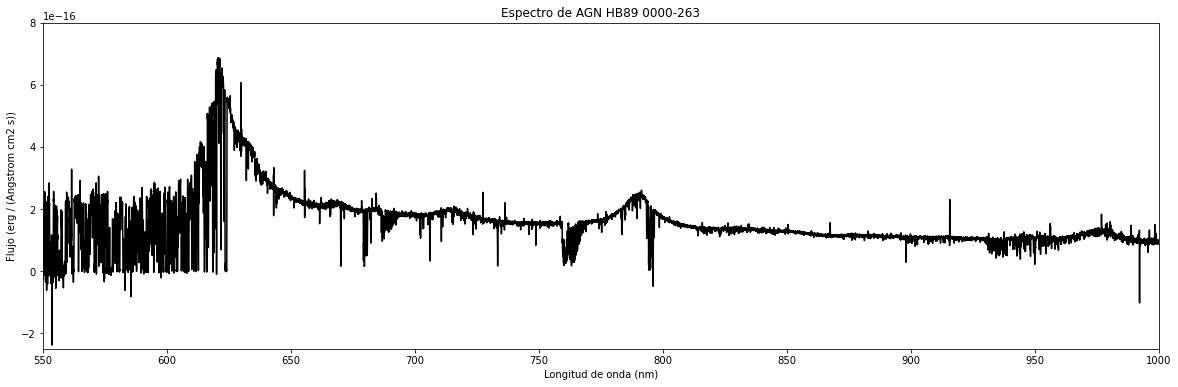

In [41]:
#Visualizavión del espectro
quantity_support()
plt.figure(figsize=(20,6))
plt.plot(wavelength, flux, color = "black")
plt.xlim(550,1000)
if AGN == "HB89 0000-263":
    plt.ylim(-0.25e-15, 0.8e-15)
elif AGN == "PSS J0121+0347":
    plt.ylim(-0.25e-15, 0.6e-15)
plt.xlabel('Longitud de onda ({})'.format(wavelength.unit))
plt.ylabel('Flujo ({})'.format(flux.unit))
plt.title('Espectro de AGN ' + AGN)
plt.savefig(AGN+"preliminar.jpg")
plt.show()

In [42]:
#Filtrado para el ajuste del continuo
wave = datos[1].data
i = wavelength>550 *u.nm

wavelengths = wave[0][0][i]*u.nm
fluxs = wave[0][1][i]
ERRs = wave[0][2][i]
Quals = wave[0][3][i]
Snrs = wave[0][4][i]
Flux_reduceds = wave[0][5][i]
Err_reduceds = wave[0][6][i]

print(wavelengths)

[ 550.02  550.04  550.06 ... 1019.96 1019.98 1020.  ] nm


In [43]:
# Definir la función del modelo
def combined_model(wavelengt, line_center_nm, alpha, amplitude, c0, c1, c2, c3):

    # Convertir el centro de la línea a unidades de Angstrom
    line_center = line_center_nm
    
    # Ley de potencias
    powerlaw_model = amplitude * ((wavelengt / line_center) ** alpha)

    # Polinomio de grado 3
    polynomial_model = c0 + c1 * (wavelengt) + c2 * (wavelengt)**2 + c3 * (wavelengt)**3

    res = (powerlaw_model + polynomial_model)

    return res

# Encontrar picos en el espectro (posibles líneas espectrales)
contador = 0 
peaks, _ = find_peaks(fluxs, height=2e-16)


# Establecer valores iniciales para los parámetros dependiendo del AGN
if AGN == "HB89 0000-263":
    initial_params = [656.3, -2, 20e-17, -1e-20, -1e-22, -1e-24, -1e-26]

elif AGN == "PSS J0121+0347":
    initial_params = [656.3, -2, 6e-17, -1e-20, -1e-22, -1e-24, -1e-26]
    
    
#Generar los dos modelos, model es scipy y model1 es manual
fitted_model = combined_model(wavelengths.value, *initial_params)
fitted_model1 = combined_model(wavelengths.value, *initial_params)


# Ajustar el modelo de scipy a los datos utilizando curve_fit
optimal_params, covariance = curve_fit(combined_model, (wavelengths[peaks]), (fluxs[peaks]/(u.erg/(u.Angstrom * u.cm * u.cm * u.s))), p0=initial_params, maxfev=500000)
contador = 0
#print(3)
#print(optimal_params)
# Obtener el modelo ajustado
fitted_model = combined_model(wavelengths.value, *optimal_params)*u.erg/(u.Angstrom * u.cm * u.cm * u.s)

print(optimal_params)

[ 2.93483172e-01  5.69697838e-01  5.51211598e-14 -1.18245313e-12
 -6.40646354e-15  2.58862409e-18 -6.71189777e-22]


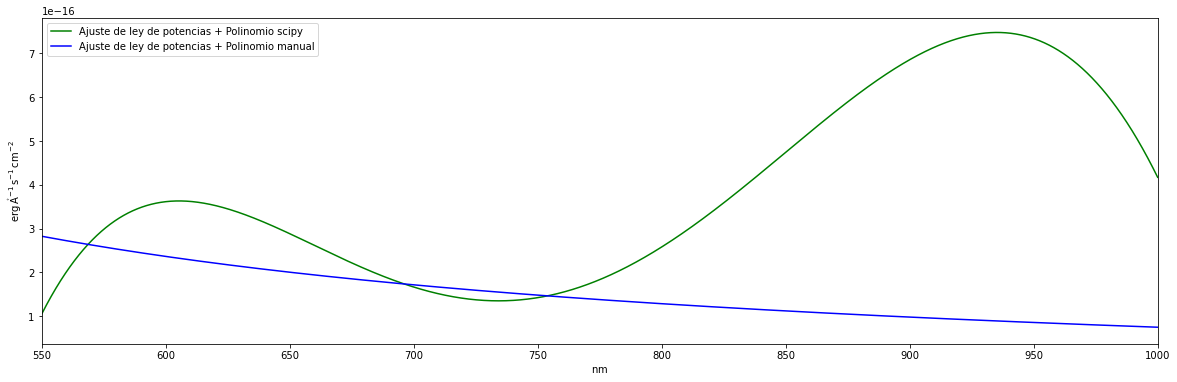

In [44]:
# Visualizar el ajuste
plt.figure(figsize=(20,6))
plt.plot(wavelengths, fitted_model, label='Ajuste de ley de potencias + Polinomio scipy', color='green')
plt.plot(wavelengths, fitted_model1, label='Ajuste de ley de potencias + Polinomio manual', color='blue')
plt.xlim(550,1000)
#plt.ylim(-0.25e-15, 0.8e-15)
plt.legend()
plt.savefig(AGN+" Ajustes.jpg")
plt.show()

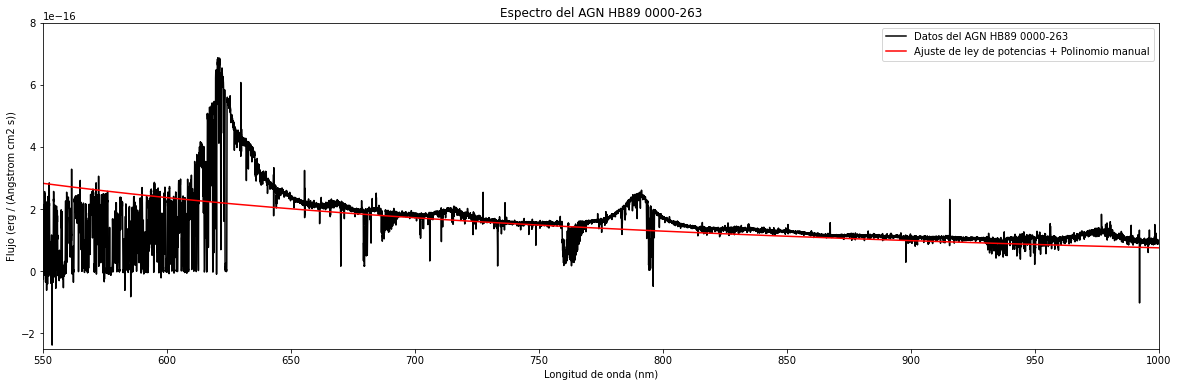

In [45]:
#Visualizavión del espectro con el continuo
quantity_support()
plt.figure(figsize=(20,6))
plt.plot(wavelength, flux, label='Datos del AGN '+ AGN, color='black')
#plt.plot(wavelengths, fitted_model, label='Ajuste de ley de potencias + Polinomio scipy', color='green')
plt.plot(wavelengths, fitted_model1, label='Ajuste de ley de potencias + Polinomio manual', color='red')
plt.xlim(550,1000)
if AGN == "HB89 0000-263":
    plt.ylim(-0.25e-15, 0.8e-15)
elif AGN == "PSS J0121+0347":
    plt.ylim(-0.25e-15, 0.6e-15)
plt.xlabel('Longitud de onda ({})'.format(wavelength.unit))
plt.ylabel('Flujo ({})'.format(flux.unit))
plt.legend()
plt.title('Espectro del AGN '+ AGN)
plt.savefig(AGN+" Ajuste ideal.jpg")
plt.show()

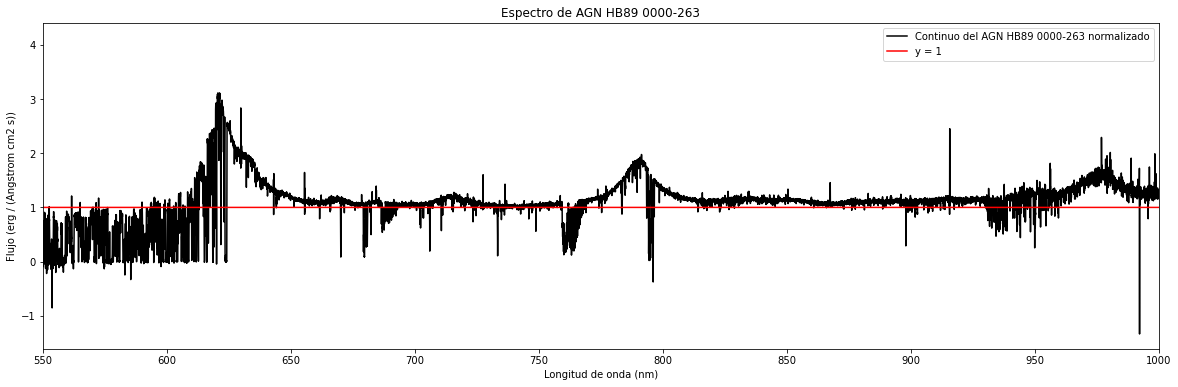

In [46]:
#Visualizavión normalizada
flux_nom = fluxs/fitted_model1
quantity_support()
plt.figure(figsize=(20,6))
plt.plot(wavelengths, flux_nom, label= "Continuo del AGN " + AGN + " normalizado", color = "black")
plt.plot(wavelengths, flux_nom/flux_nom, label = "y = 1", color = "red")
plt.xlim(550,1000)
plt.xlabel('Longitud de onda ({})'.format(wavelength.unit))
plt.ylabel('Flujo ({})'.format(flux.unit))
plt.legend()
plt.title('Espectro de AGN ' + AGN)
plt.savefig(AGN+".jpg")
plt.show()

hola
El pico se encuentra en [623.46 634.2 ] nm con una intensidad cercana a los [7.17916345 2.01298096] erg / (Angstrom cm2 s)
Parámetros óptimos: [  2.98601842 626.31831611  10.01592131]
Matriz de covarianza: [[ 0.00266475  0.00199202 -0.00843849]
 [ 0.00199202  0.05887137 -0.02852206]
 [-0.00843849 -0.02852206  0.07595055]]
Parámetros óptimos: [  4.31665132 623.44126803   0.86011512]
Matriz de covarianza: [[ 1.08645079e-02 -5.78821744e-08 -1.23282684e-02]
 [-5.78821744e-08  4.19677175e-02  9.85193703e-08]
 [-1.23282684e-02  9.85193703e-08  4.19677178e-02]]
El pico se encuentra en [794.52] nm con una intensidad cercana a los [2.59543122] erg / (Angstrom cm2 s)
Parámetros óptimos: [  2.35935388 794.17199042   3.12283019]
Matriz de covarianza: [[ 1.90141779e-04 -1.26833949e-05 -3.16467496e-04]
 [-1.26833949e-05  5.38415319e-04  7.33472530e-05]
 [-3.16467496e-04  7.33472530e-05  1.20005914e-03]]
Parámetros óptimos: [2.52566224e-01 7.94564615e+02 3.64595036e-01]
Matriz de covarianza: [[ 

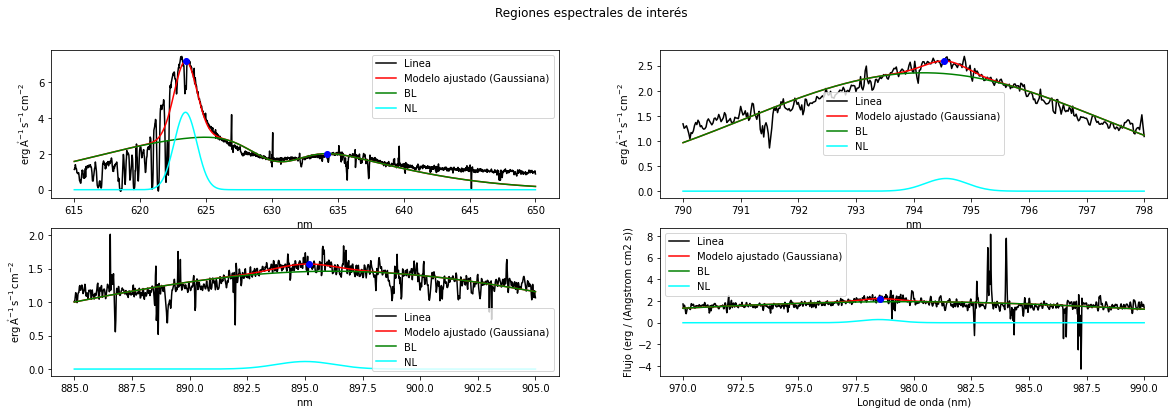

In [33]:
#Segmentación por lineas
def modelo_gaussiano(x, a, mu, sigma):
    return a * np.exp(-(x - mu)**2 / (2 * sigma**2))

if AGN == "HB89 0000-263":
    
    
    #Linea 1
    flux = flux_nom *u.erg/(u.Angstrom * u.cm * u.cm * u.s)
    spectrum = Spectrum1D(spectral_axis=wavelengths, flux=flux)

    region_of_interest1 = SpectralRegion(600*u.nm, 650*u.nm)


    mask1 = (wavelengths >= region_of_interest1.lower) & (wavelengths <= region_of_interest1.upper)


    sub_spectrum1 = Spectrum1D(spectral_axis=wavelengths[mask1], flux=flux[mask1])



    # Ajustar el modelo a los datos
    parametros_optimos, matriz_covarianza = curve_fit(modelo_gaussiano, wavelengths[mask1], flux[mask1], p0=[10, 600, 0.05])


    ajuste1 = sub_spectrum1.flux-modelo_gaussiano(wavelengths[mask1].value, *parametros_optimos)*u.erg/(u.Angstrom * u.cm * u.cm * u.s)

    parametros_optimos2, matriz_covarianza2 = curve_fit(modelo_gaussiano, wavelengths[mask1], ajuste1.value, p0=[3, 620, 5])
    ajuste_to = modelo_gaussiano(wavelengths[mask1].value, *parametros_optimos)+modelo_gaussiano(wavelengths[mask1].value, *parametros_optimos2)

    peaks_ajust, _ = find_peaks(ajuste_to, height=2.2)
    print("El pico se encuentra en " + str(sub_spectrum1.spectral_axis[peaks_ajust])+ " con una intensidad cercana a los " +str(ajuste_to[peaks_ajust]*u.erg/(u.Angstrom * u.cm * u.cm * u.s)))

    """plt.figure(figsize=(20,6))
    plt.plot(sub_spectrum1.spectral_axis, sub_spectrum1.flux, color="black", label='Linea')
    plt.plot(sub_spectrum1.spectral_axis, ajuste_to, color='red', label='Modelo ajustado (Gaussiana)')
    plt.plot(sub_spectrum1.spectral_axis[peaks_ajust], ajuste_to[peaks_ajust], 'bo')
    plt.xlabel('Longitud de onda ({})'.format(sub_spectrum1.spectral_axis.unit))
    plt.ylabel('Flujo ({})'.format(sub_spectrum1.flux.unit))
    plt.legend()
    plt.title('Región espectral de interés')
    plt.show()"""

    print("Parámetros óptimos:", parametros_optimos)
    print("Matriz de covarianza:", matriz_covarianza)
    print("Parámetros óptimos:", parametros_optimos2)
    print("Matriz de covarianza:", matriz_covarianza2)
    
    #linea 2
    region_of_interest2 = SpectralRegion(660*u.nm, 675*u.nm)


    mask2 = (wavelengths >= region_of_interest2.lower) & (wavelengths <= region_of_interest2.upper)


    sub_spectrum2 = Spectrum1D(spectral_axis=wavelengths[mask2], flux=flux[mask2])

    # Ajustar el modelo a los datos
    parametros_optimosl2, matriz_covarianzal2 = curve_fit(modelo_gaussiano, wavelengths[mask2], flux[mask2], p0=[1, 667, 20])


    ajuste1l2 = modelo_gaussiano(wavelengths[mask2].value, *parametros_optimosl2)*u.erg/(u.Angstrom * u.cm * u.cm * u.s)


    peaks_ajustl2, _ = find_peaks(ajuste1l2, height=1)
    print("El pico se encuentra en " + str(sub_spectrum2.spectral_axis[peaks_ajustl2])+ " con una intensidad cercana a los " +str(ajuste1l2[peaks_ajustl2]*u.erg/(u.Angstrom * u.cm * u.cm * u.s)))

    """plt.figure(figsize=(20,6))
    plt.plot(sub_spectrum2.spectral_axis, sub_spectrum2.flux, color="black", label='Linea')
    plt.plot(sub_spectrum2.spectral_axis, ajuste1l2, color='red', label='Modelo ajustado (Gaussiana)')
    plt.plot(sub_spectrum2.spectral_axis[peaks_ajustl2], ajuste1l2[peaks_ajustl2], 'bo')
    plt.xlabel('Longitud de onda ({})'.format(sub_spectrum1.spectral_axis.unit))
    plt.ylabel('Flujo ({})'.format(sub_spectrum1.flux.unit))
    plt.legend()
    plt.title('Región espectral de interés')
    plt.show()"""

    print("Parámetros óptimos:", parametros_optimosl2)
    print("Matriz de covarianza:", matriz_covarianzal2)
    
    #linea 3
    region_of_interest3 = SpectralRegion(700*u.nm, 725*u.nm)


    mask3 = (wavelengths >= region_of_interest3.lower) & (wavelengths <= region_of_interest3.upper)


    sub_spectrum3 = Spectrum1D(spectral_axis=wavelengths[mask3], flux=flux[mask3])

    # Ajustar el modelo a los datos
    parametros_optimosl3, matriz_covarianzal3 = curve_fit(modelo_gaussiano, wavelengths[mask3], flux[mask3], p0=[10, 720, 0.05])


    ajuste1l3 = modelo_gaussiano(wavelengths[mask3].value, *parametros_optimosl3)*u.erg/(u.Angstrom * u.cm * u.cm * u.s)


    peaks_ajustl3, _ = find_peaks(ajuste1l3, height=1)
    print("El pico se encuentra en " + str(sub_spectrum3.spectral_axis[peaks_ajustl3])+ " con una intensidad cercana a los " +str(ajuste1l3[peaks_ajustl3]*u.erg/(u.Angstrom * u.cm * u.cm * u.s)))

    """plt.figure(figsize=(20,6))
    plt.plot(sub_spectrum3.spectral_axis, sub_spectrum3.flux, color="black", label='Linea')
    plt.plot(sub_spectrum3.spectral_axis, ajuste1l3, color='red', label='Modelo ajustado (Gaussiana)')
    plt.plot(sub_spectrum3.spectral_axis[peaks_ajustl3], ajuste1l3[peaks_ajustl3], 'bo')
    plt.xlabel('Longitud de onda ({})'.format(sub_spectrum1.spectral_axis.unit))
    plt.ylabel('Flujo ({})'.format(sub_spectrum1.flux.unit))
    plt.legend()
    plt.title('Región espectral de interés')
    plt.show()"""

    print("Parámetros óptimos:", parametros_optimosl3)
    print("Matriz de covarianza:", matriz_covarianzal3)
    
    #linea 4
    region_of_interest4 = SpectralRegion(775*u.nm, 805*u.nm)


    mask4 = (wavelengths >= region_of_interest4.lower) & (wavelengths <= region_of_interest4.upper)


    sub_spectrum4 = Spectrum1D(spectral_axis=wavelengths[mask4], flux=flux[mask4])


    # Ajustar el modelo a los datos
    parametros_optimosl4, matriz_covarianzal4 = curve_fit(modelo_gaussiano, wavelengths[mask4], flux[mask4], p0=[1.5, 790, 0.05])


    ajuste1l4 = sub_spectrum4.flux-modelo_gaussiano(wavelengths[mask4].value, *parametros_optimosl4)*u.erg/(u.Angstrom * u.cm * u.cm * u.s)

    parametros_optimos2l4, matriz_covarianza2l4 = curve_fit(modelo_gaussiano, wavelengths[mask4], ajuste1l4.value, p0=[0.1, 790, 5])
    ajuste_tol4 = modelo_gaussiano(wavelengths[mask4].value, *parametros_optimosl4)+modelo_gaussiano(wavelengths[mask4].value, *parametros_optimos2l4)

    peaks_ajustl4, _ = find_peaks(ajuste_tol4, height=1)
    print("El pico se encuentra en " + str(sub_spectrum4.spectral_axis[peaks_ajustl4])+ " con una intensidad cercana a los " +str(ajuste_tol4[peaks_ajustl4]*u.erg/(u.Angstrom * u.cm * u.cm * u.s)))

    """"plt.figure(figsize=(20,6))
    plt.plot(sub_spectrum4.spectral_axis, sub_spectrum4.flux, color="black", label='Linea')
    plt.plot(sub_spectrum4.spectral_axis, ajuste_tol4, color='red', label='Modelo ajustado (Gaussiana)')
    plt.plot(sub_spectrum4.spectral_axis[peaks_ajustl4], ajuste_tol4[peaks_ajustl4], 'bo')
    plt.xlabel('Longitud de onda ({})'.format(sub_spectrum1.spectral_axis.unit))
    plt.ylabel('Flujo ({})'.format(sub_spectrum1.flux.unit))
    plt.legend()
    plt.title('Región espectral de interés')
    plt.show()"""

    print("Parámetros óptimos:", parametros_optimosl4)
    print("Matriz de covarianza:", matriz_covarianzal4)
    print("Parámetros óptimos:", parametros_optimos2l4)
    print("Matriz de covarianza:", matriz_covarianza2l4)

    #todas juntas
    figure, axis = plt.subplots(2, 2, figsize=(20,6))
    figure.suptitle("Regiones espectrales de interés")
    axis[0,0].plot(sub_spectrum1.spectral_axis, sub_spectrum1.flux, color="black", label='Linea')
    axis[0,0].plot(sub_spectrum1.spectral_axis, ajuste_to, color='red', label='Modelo ajustado (Gaussiana)')
    axis[0,0].plot(sub_spectrum1.spectral_axis, modelo_gaussiano(wavelengths[mask1].value, *parametros_optimos), color="green", label='BL')
    axis[0,0].plot(sub_spectrum1.spectral_axis, modelo_gaussiano(wavelengths[mask1].value, *parametros_optimos2), color="cyan", label='NL')
    axis[0,0].plot(sub_spectrum1.spectral_axis[peaks_ajust], ajuste_to[peaks_ajust], 'bo')
    axis[0,0].legend()
    #axis[0,0].set_title('Región espectral de interés')
    
    axis[0,1].plot(sub_spectrum2.spectral_axis, sub_spectrum2.flux, color="black", label='Linea')
    axis[0,1].plot(sub_spectrum2.spectral_axis, ajuste1l2, color='red', label='Modelo ajustado (Gaussiana)')
    axis[0,1].plot(sub_spectrum2.spectral_axis, ajuste1l2-1.05*u.erg/(u.Angstrom * u.cm * u.cm * u.s), color="green", label='BL')
    axis[0,1].plot(sub_spectrum2.spectral_axis[peaks_ajustl2], ajuste1l2[peaks_ajustl2], 'bo')
    axis[0,1].legend()
    #axis[0,1].set_title('Región espectral de interés')
    
    axis[1,0].plot(sub_spectrum3.spectral_axis, sub_spectrum3.flux, color="black", label='Linea')
    axis[1,0].plot(sub_spectrum3.spectral_axis, ajuste1l3, color='red', label='Modelo ajustado (Gaussiana)')
    axis[1,0].plot(sub_spectrum3.spectral_axis, ajuste1l3-1.05*u.erg/(u.Angstrom * u.cm * u.cm * u.s), color="green", label='BL')
    axis[1,0].plot(sub_spectrum3.spectral_axis[peaks_ajustl3], ajuste1l3[peaks_ajustl3], 'bo')
    axis[1,0].legend()
    #axis[1,0].set_title('Región espectral de interés')
    
    axis[1,1].plot(sub_spectrum4.spectral_axis, sub_spectrum4.flux, color="black", label='Linea')
    axis[1,1].plot(sub_spectrum4.spectral_axis, ajuste_tol4, color='red', label='Modelo ajustado (Gaussiana)')
    axis[1,1].plot(sub_spectrum4.spectral_axis, (modelo_gaussiano(wavelengths[mask4].value, *parametros_optimosl4)+modelo_gaussiano(wavelengths[mask4].value, *parametros_optimos2l4))-1.05, color="green", label='BL')
    axis[1,1].plot(sub_spectrum4.spectral_axis[peaks_ajustl4], ajuste_tol4[peaks_ajustl4], 'bo')
    axis[1,1].legend()
    #axis[1,1].set_title('Región espectral de interés')
    
    plt.xlabel('Longitud de onda ({})'.format(sub_spectrum1.spectral_axis.unit))
    plt.ylabel('Flujo ({})'.format(sub_spectrum1.flux.unit))
    plt.savefig("Regiones espectrales de interés del AGN "+AGN+".jpg")
    
    picos = [sub_spectrum1.spectral_axis[peaks_ajust], sub_spectrum2.spectral_axis[peaks_ajustl2], sub_spectrum3.spectral_axis[peaks_ajustl3], sub_spectrum4.spectral_axis[peaks_ajustl4]]
    i_picos = [ajuste_to[peaks_ajust],ajuste1l2[peaks_ajustl2],ajuste1l3[peaks_ajustl3],ajuste_tol4[peaks_ajustl4]]
    
elif AGN == "PSS J0121+0347":
    print("hola")
    #Linea 1
    flux = flux_nom *u.erg/(u.Angstrom * u.cm * u.cm * u.s)
    spectrum = Spectrum1D(spectral_axis=wavelengths, flux=flux)

    region_of_interest1 = SpectralRegion(615*u.nm, 650*u.nm)


    mask1 = (wavelengths >= region_of_interest1.lower) & (wavelengths <= region_of_interest1.upper)


    sub_spectrum1 = Spectrum1D(spectral_axis=wavelengths[mask1], flux=flux[mask1])



    # Ajustar el modelo a los datos
    parametros_optimos, matriz_covarianza = curve_fit(modelo_gaussiano, wavelengths[mask1], flux[mask1], p0=[3, 622, 0.05])


    ajuste1 = sub_spectrum1.flux-modelo_gaussiano(wavelengths[mask1].value, *parametros_optimos)*u.erg/(u.Angstrom * u.cm * u.cm * u.s)

    parametros_optimos2, matriz_covarianza2 = curve_fit(modelo_gaussiano, wavelengths[mask1], ajuste1.value, p0=[3, 620, 5])
    ajuste_2 = sub_spectrum1.flux-(modelo_gaussiano(wavelengths[mask1].value, *parametros_optimos)+modelo_gaussiano(wavelengths[mask1].value, *parametros_optimos2))*u.erg/(u.Angstrom * u.cm * u.cm * u.s)

    parametros_optimos3, matriz_covarianza2 = curve_fit(modelo_gaussiano, wavelengths[mask1], ajuste1.value, p0=[3, 635, 5])
    ajuste_to = modelo_gaussiano(wavelengths[mask1].value, *parametros_optimos)+modelo_gaussiano(wavelengths[mask1].value, *parametros_optimos2)+modelo_gaussiano(wavelengths[mask1].value, *parametros_optimos3)
    peaks_ajust, _ = find_peaks(ajuste_to, height=2.0)
    print("El pico se encuentra en " + str(sub_spectrum1.spectral_axis[peaks_ajust])+ " con una intensidad cercana a los " +str(ajuste_to[peaks_ajust]*u.erg/(u.Angstrom * u.cm * u.cm * u.s)))

    """plt.figure(figsize=(20,6))
    plt.plot(sub_spectrum1.spectral_axis, sub_spectrum1.flux, color="black", label='Linea')
    plt.plot(sub_spectrum1.spectral_axis, ajuste_to, color='red', label='Modelo ajustado (Gaussiana)')
    plt.plot(sub_spectrum1.spectral_axis[peaks_ajust], ajuste_to[peaks_ajust], 'bo')
    plt.xlabel('Longitud de onda ({})'.format(sub_spectrum1.spectral_axis.unit))
    plt.ylabel('Flujo ({})'.format(sub_spectrum1.flux.unit))
    plt.legend()
    plt.title('Región espectral de interés')
    plt.show()"""

    print("Parámetros óptimos:", parametros_optimos)
    print("Matriz de covarianza:", matriz_covarianza)
    print("Parámetros óptimos:", parametros_optimos2)
    print("Matriz de covarianza:", matriz_covarianza2)
    
    #linea 2
    region_of_interest2 = SpectralRegion(790*u.nm, 798*u.nm)


    mask2 = (wavelengths >= region_of_interest2.lower) & (wavelengths <= region_of_interest2.upper)


    sub_spectrum2 = Spectrum1D(spectral_axis=wavelengths[mask2], flux=flux[mask2])

    # Ajustar el modelo a los datos
    parametros_optimosl2, matriz_covarianzal2 = curve_fit(modelo_gaussiano, wavelengths[mask2], flux[mask2], p0=[2, 795, 5])


    ajuste1l2 = sub_spectrum2.flux-(modelo_gaussiano(wavelengths[mask2].value, *parametros_optimosl2))*u.erg/(u.Angstrom * u.cm * u.cm * u.s)

    parametros_optimos2l2, matriz_covarianza2l2 = curve_fit(modelo_gaussiano, wavelengths[mask2], ajuste1l2.value, p0=[0.3, 794.5, 0.5])
    ajuste_to2 = modelo_gaussiano(wavelengths[mask2].value, *parametros_optimosl2)+modelo_gaussiano(wavelengths[mask2].value, *parametros_optimos2l2)
    peaks_ajustl2, _ = find_peaks(ajuste_to2, height=1)
    print("El pico se encuentra en " + str(sub_spectrum2.spectral_axis[peaks_ajustl2])+ " con una intensidad cercana a los " +str(ajuste_to2[peaks_ajustl2]*u.erg/(u.Angstrom * u.cm * u.cm * u.s)))

    """plt.figure(figsize=(20,6))
    plt.plot(sub_spectrum2.spectral_axis, sub_spectrum2.flux, color="black", label='Linea')
    plt.plot(sub_spectrum2.spectral_axis, ajuste_to2, color='red', label='Modelo ajustado (Gaussiana)')
    plt.plot(sub_spectrum2.spectral_axis[peaks_ajustl2], ajuste_to2[peaks_ajustl2], 'bo')
    plt.xlabel('Longitud de onda ({})'.format(sub_spectrum1.spectral_axis.unit))
    plt.ylabel('Flujo ({})'.format(sub_spectrum1.flux.unit))
    plt.legend()
    plt.title('Región espectral de interés')
    plt.show()"""

    print("Parámetros óptimos:", parametros_optimosl2)
    print("Matriz de covarianza:", matriz_covarianzal2)

    print("Parámetros óptimos:", parametros_optimos2l2)
    print("Matriz de covarianza:", matriz_covarianza2l2)
    
    #linea 3
    region_of_interest3 = SpectralRegion(885*u.nm, 905*u.nm)


    mask3 = (wavelengths >= region_of_interest3.lower) & (wavelengths <= region_of_interest3.upper)


    sub_spectrum3 = Spectrum1D(spectral_axis=wavelengths[mask3], flux=flux[mask3])

    # Ajustar el modelo a los datos
    parametros_optimosl3, matriz_covarianzal3 = curve_fit(modelo_gaussiano, wavelengths[mask3], flux[mask3], p0=[0.5, 895, 0.55])

    ajuste1l3 = sub_spectrum3.flux-(modelo_gaussiano(wavelengths[mask3].value, *parametros_optimosl3)*u.erg/(u.Angstrom * u.cm * u.cm * u.s))

    parametros_optimos3l2, matriz_covarianza3l2 = curve_fit(modelo_gaussiano, wavelengths[mask3], ajuste1l3.value, p0=[0.3, 895, 0.5])
    ajuste_to3 = modelo_gaussiano(wavelengths[mask3].value, *parametros_optimosl3)+modelo_gaussiano(wavelengths[mask3].value, *parametros_optimos3l2)

    peaks_ajustl3, _ = find_peaks(ajuste_to3, height=1)
    print("El pico se encuentra en " + str(sub_spectrum3.spectral_axis[peaks_ajustl3])+ " con una intensidad cercana a los " +str(ajuste1l3[peaks_ajustl3]*u.erg/(u.Angstrom * u.cm * u.cm * u.s)))

    """plt.figure(figsize=(20,6))
    plt.plot(sub_spectrum3.spectral_axis, sub_spectrum3.flux, color="black", label='Linea')
    plt.plot(sub_spectrum3.spectral_axis, ajuste_to3, color='red', label='Modelo ajustado (Gaussiana)')
    plt.plot(sub_spectrum3.spectral_axis[peaks_ajustl3], ajuste_to3[peaks_ajustl3], 'bo')
    plt.xlabel('Longitud de onda ({})'.format(sub_spectrum1.spectral_axis.unit))
    plt.ylabel('Flujo ({})'.format(sub_spectrum1.flux.unit))
    plt.legend()
    plt.title('Región espectral de interés')
    plt.show()"""

    print("Parámetros óptimos:", parametros_optimosl3)
    print("Matriz de covarianza:", matriz_covarianzal3)

    print("Parámetros óptimos:", parametros_optimos3l2)
    print("Matriz de covarianza:", matriz_covarianza3l2)

    #linea 4
    region_of_interest4 = SpectralRegion(970*u.nm, 990*u.nm)


    mask4 = (wavelengths >= region_of_interest4.lower) & (wavelengths <= region_of_interest4.upper)


    sub_spectrum4 = Spectrum1D(spectral_axis=wavelengths[mask4], flux=flux[mask4])


    # Ajustar el modelo a los datos
    parametros_optimosl4, matriz_covarianzal4 = curve_fit(modelo_gaussiano, wavelengths[mask4], flux[mask4], p0=[1.5, 978, 0.05])


    ajuste1l4 = sub_spectrum4.flux-modelo_gaussiano(wavelengths[mask4].value, *parametros_optimosl4)*u.erg/(u.Angstrom * u.cm * u.cm * u.s)

    parametros_optimos2l4, matriz_covarianza2l4 = curve_fit(modelo_gaussiano, wavelengths[mask4], ajuste1l4.value, p0=[0.1, 978, 5])
    ajuste_tol4 = modelo_gaussiano(wavelengths[mask4].value, *parametros_optimosl4)+modelo_gaussiano(wavelengths[mask4].value, *parametros_optimos2l4)

    peaks_ajustl4, _ = find_peaks(ajuste_tol4, height=1)
    print("El pico se encuentra en " + str(sub_spectrum4.spectral_axis[peaks_ajustl4])+ " con una intensidad cercana a los " +str(ajuste_tol4[peaks_ajustl4]*u.erg/(u.Angstrom * u.cm * u.cm * u.s)))

    """plt.figure(figsize=(20,6))
    plt.plot(sub_spectrum4.spectral_axis, sub_spectrum4.flux, color="black", label='Linea')
    plt.plot(sub_spectrum4.spectral_axis, ajuste_tol4, color='red', label='Modelo ajustado (Gaussiana)')
    plt.plot(sub_spectrum4.spectral_axis[peaks_ajustl4], ajuste_tol4[peaks_ajustl4], 'bo')
    plt.xlabel('Longitud de onda ({})'.format(sub_spectrum1.spectral_axis.unit))
    plt.ylabel('Flujo ({})'.format(sub_spectrum1.flux.unit))
    plt.legend()
    plt.title('Región espectral de interés')
    plt.show()"""

    print("Parámetros óptimos:", parametros_optimosl4)
    print("Matriz de covarianza:", matriz_covarianzal4)
    print("Parámetros óptimos:", parametros_optimos2l4)
    print("Matriz de covarianza:", matriz_covarianza2l4)

    #todas juntas
    figure, axis = plt.subplots(2, 2, figsize=(20,6))
    figure.suptitle("Regiones espectrales de interés")
    axis[0,0].plot(sub_spectrum1.spectral_axis, sub_spectrum1.flux, color="black", label='Linea')
    axis[0,0].plot(sub_spectrum1.spectral_axis, ajuste_to, color='red', label='Modelo ajustado (Gaussiana)')
    axis[0,0].plot(sub_spectrum1.spectral_axis, modelo_gaussiano(wavelengths[mask1].value, *parametros_optimos)+modelo_gaussiano(wavelengths[mask1].value, *parametros_optimos3), color="green", label='BL')
    axis[0,0].plot(sub_spectrum1.spectral_axis, modelo_gaussiano(wavelengths[mask1].value, *parametros_optimos2) , color="cyan", label='NL')
    axis[0,0].plot(sub_spectrum1.spectral_axis[peaks_ajust], ajuste_to[peaks_ajust], 'bo')
    axis[0,0].legend()
    #axis[0,0].set_title('Región espectral de interés')
    
    axis[0,1].plot(sub_spectrum2.spectral_axis, sub_spectrum2.flux, color="black", label='Linea')
    axis[0,1].plot(sub_spectrum2.spectral_axis, ajuste_to2, color='red', label='Modelo ajustado (Gaussiana)')
    axis[0,1].plot(sub_spectrum2.spectral_axis, modelo_gaussiano(wavelengths[mask2].value, *parametros_optimosl2), color="green", label='BL')
    axis[0,1].plot(sub_spectrum2.spectral_axis, modelo_gaussiano(wavelengths[mask2].value, *parametros_optimos2l2) , color="cyan", label='NL')
    axis[0,1].plot(sub_spectrum2.spectral_axis[peaks_ajustl2], ajuste_to2[peaks_ajustl2], 'bo')
    axis[0,1].legend()
    #axis[0,1].set_title('Región espectral de interés')
    
    axis[1,0].plot(sub_spectrum3.spectral_axis, sub_spectrum3.flux, color="black", label='Linea')
    axis[1,0].plot(sub_spectrum3.spectral_axis, ajuste_to3, color='red', label='Modelo ajustado (Gaussiana)')
    axis[1,0].plot(sub_spectrum3.spectral_axis, modelo_gaussiano(wavelengths[mask3].value, *parametros_optimosl3), color="green", label='BL')
    axis[1,0].plot(sub_spectrum3.spectral_axis, modelo_gaussiano(wavelengths[mask3].value, *parametros_optimos3l2) , color="cyan", label='NL')
    axis[1,0].plot(sub_spectrum3.spectral_axis[peaks_ajustl3], ajuste_to3[peaks_ajustl3], 'bo')
    axis[1,0].legend()
    #axis[1,0].set_title('Región espectral de interés')
    
    axis[1,1].plot(sub_spectrum4.spectral_axis, sub_spectrum4.flux, color="black", label='Linea')
    axis[1,1].plot(sub_spectrum4.spectral_axis, ajuste_tol4, color='red', label='Modelo ajustado (Gaussiana)')
    axis[1,1].plot(sub_spectrum4.spectral_axis, modelo_gaussiano(wavelengths[mask4].value, *parametros_optimosl4), color="green", label='BL')
    axis[1,1].plot(sub_spectrum4.spectral_axis, modelo_gaussiano(wavelengths[mask4].value, *parametros_optimos2l4) , color="cyan", label='NL')
    axis[1,1].plot(sub_spectrum4.spectral_axis[peaks_ajustl4], ajuste_tol4[peaks_ajustl4], 'bo')
    axis[1,1].legend()
    #axis[1,1].set_title('Región espectral de interés')
    
    plt.xlabel('Longitud de onda ({})'.format(sub_spectrum1.spectral_axis.unit))
    plt.ylabel('Flujo ({})'.format(sub_spectrum1.flux.unit))
    plt.savefig("Regiones espectrales de interés del AGN "+AGN+".jpg")
    
    picos = [sub_spectrum1.spectral_axis[peaks_ajust], sub_spectrum2.spectral_axis[peaks_ajustl2], sub_spectrum3.spectral_axis[peaks_ajustl3], sub_spectrum4.spectral_axis[peaks_ajustl4]]
    i_picos = [ajuste_to[peaks_ajust],ajuste_to2[peaks_ajustl2],ajuste1l3[peaks_ajustl3],ajuste_tol4[peaks_ajustl4]]

print(picos)
print(i_picos)

El pico se encuentra en [623.46 634.2 ] nm con una intensidad cercana a los [7.17916345 2.01298096] erg / (Angstrom cm2 s)


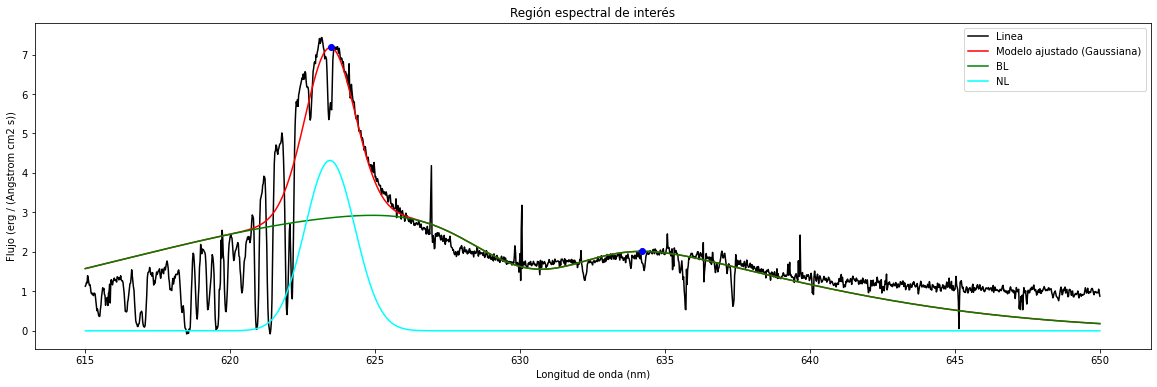

Parámetros óptimos: [  2.98601842 626.31831611  10.01592131]
Matriz de covarianza: [[ 0.00266475  0.00199202 -0.00843849]
 [ 0.00199202  0.05887137 -0.02852206]
 [-0.00843849 -0.02852206  0.07595055]]
Incertidumbres de los parámetros: [0.0516212  0.24263424 0.27559128]
Parámetros óptimos: [  4.31665132 623.44126803   0.86011512]
Matriz de covarianza: [[ 1.20346676e-02  1.72674164e-08 -1.59887343e-03]
 [ 1.72674164e-08  6.37258054e-04 -3.44126775e-09]
 [-1.59887343e-03 -3.44126775e-09  6.37258052e-04]]
Incertidumbres de los parámetros: [0.10970263 0.02524397 0.02524397]
Parámetros óptimos: [ -1.17527456 630.31238129  -2.00074012]
Matriz de covarianza: [[ 1.08645079e-02 -5.78821744e-08 -1.23282684e-02]
 [-5.78821744e-08  4.19677175e-02  9.85193703e-08]
 [-1.23282684e-02  9.85193703e-08  4.19677178e-02]]
Incertidumbres de los parámetros: [0.10423295 0.20486024 0.20486024]


In [34]:
flux = flux_nom *u.erg/(u.Angstrom * u.cm * u.cm * u.s)
spectrum = Spectrum1D(spectral_axis=wavelengths, flux=flux)

region_of_interest1 = SpectralRegion(615*u.nm, 650*u.nm)


mask1 = (wavelengths >= region_of_interest1.lower) & (wavelengths <= region_of_interest1.upper)


sub_spectrum1 = Spectrum1D(spectral_axis=wavelengths[mask1], flux=flux[mask1])



# Ajustar el modelo a los datos
parametros_optimos, matriz_covarianza = curve_fit(modelo_gaussiano, wavelengths[mask1], flux[mask1], p0=[3, 622, 0.05])


ajuste1 = sub_spectrum1.flux-modelo_gaussiano(wavelengths[mask1].value, *parametros_optimos)*u.erg/(u.Angstrom * u.cm * u.cm * u.s)

parametros_optimos2, matriz_covarianza2 = curve_fit(modelo_gaussiano, wavelengths[mask1], ajuste1.value, p0=[3, 620, 5])
ajuste_2 = sub_spectrum1.flux-(modelo_gaussiano(wavelengths[mask1].value, *parametros_optimos)+modelo_gaussiano(wavelengths[mask1].value, *parametros_optimos2))*u.erg/(u.Angstrom * u.cm * u.cm * u.s)

parametros_optimos3, matriz_covarianza3 = curve_fit(modelo_gaussiano, wavelengths[mask1], ajuste1.value, p0=[3, 635, 5])
ajuste_to = modelo_gaussiano(wavelengths[mask1].value, *parametros_optimos)+modelo_gaussiano(wavelengths[mask1].value, *parametros_optimos2)+modelo_gaussiano(wavelengths[mask1].value, *parametros_optimos3)
peaks_ajust, _ = find_peaks(ajuste_to, height=2.0)
print("El pico se encuentra en " + str(sub_spectrum1.spectral_axis[peaks_ajust])+ " con una intensidad cercana a los " +str(ajuste_to[peaks_ajust]*u.erg/(u.Angstrom * u.cm * u.cm * u.s)))

# Calcular las incertidumbres de los parámetros ajustados
incertidumbres_parametros = np.sqrt(np.diag(matriz_covarianza))
incertidumbres_parametros2 = np.sqrt(np.diag(matriz_covarianza2))
incertidumbres_parametros3 = np.sqrt(np.diag(matriz_covarianza3))

plt.figure(figsize=(20,6))
plt.plot(sub_spectrum1.spectral_axis, sub_spectrum1.flux, color="black", label='Linea')
plt.plot(sub_spectrum1.spectral_axis, ajuste_to, color='red', label='Modelo ajustado (Gaussiana)')
plt.plot(sub_spectrum1.spectral_axis, modelo_gaussiano(wavelengths[mask1].value, *parametros_optimos)+modelo_gaussiano(wavelengths[mask1].value, *parametros_optimos3), color="green", label='BL')
plt.plot(sub_spectrum1.spectral_axis, modelo_gaussiano(wavelengths[mask1].value, *parametros_optimos2) , color="cyan", label='NL')
plt.plot(sub_spectrum1.spectral_axis[peaks_ajust], ajuste_to[peaks_ajust], 'bo')
plt.xlabel('Longitud de onda ({})'.format(sub_spectrum1.spectral_axis.unit))
plt.ylabel('Flujo ({})'.format(sub_spectrum1.flux.unit))
plt.legend()
plt.title('Región espectral de interés')
plt.show()

print("Parámetros óptimos:", parametros_optimos)
print("Matriz de covarianza:", matriz_covarianza)
print("Incertidumbres de los parámetros:", incertidumbres_parametros)
print("Parámetros óptimos:", parametros_optimos2)
print("Matriz de covarianza:", matriz_covarianza2)
print("Incertidumbres de los parámetros:", incertidumbres_parametros2)
print("Parámetros óptimos:", parametros_optimos3)
print("Matriz de covarianza:", matriz_covarianza3)
print("Incertidumbres de los parámetros:", incertidumbres_parametros3)

El pico se encuentra en [794.52] nm con una intensidad cercana a los [2.59543122] erg / (Angstrom cm2 s)


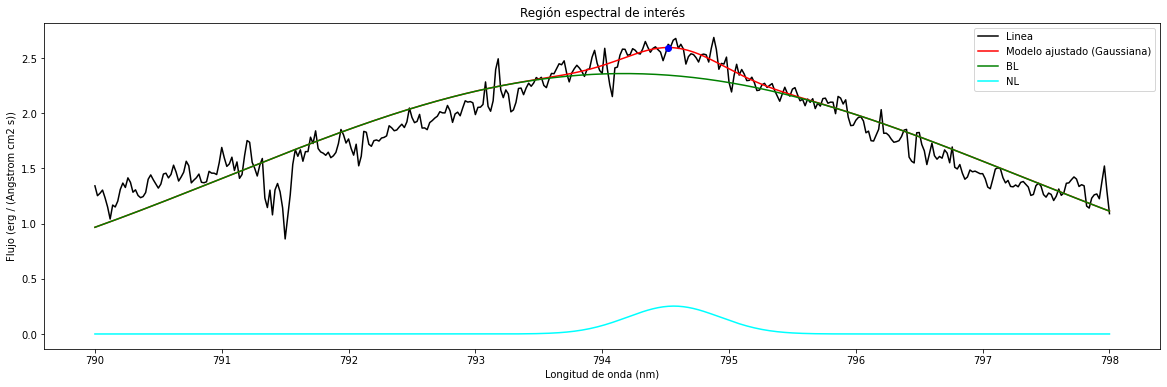

Parámetros óptimos: [  2.35935388 794.17199042   3.12283019]
Matriz de covarianza: [[ 1.90141779e-04 -1.26833949e-05 -3.16467496e-04]
 [-1.26833949e-05  5.38415319e-04  7.33472530e-05]
 [-3.16467496e-04  7.33472530e-05  1.20005914e-03]]
Incertidumbres de los parámetros: [0.01378919 0.02320378 0.03464187]
Parámetros óptimos: [2.52566224e-01 7.94564615e+02 3.64595036e-01]
Matriz de covarianza: [[ 1.03291205e-03  3.22831435e-08 -9.94213357e-04]
 [ 3.22831435e-08  2.87089359e-03 -4.66131614e-08]
 [-9.94213357e-04 -4.66131614e-08  2.87089365e-03]]
Incertidumbres de los parámetros: [0.03213895 0.05358072 0.05358072]


In [36]:
#linea 2
region_of_interest2 = SpectralRegion(790*u.nm, 798*u.nm)


mask2 = (wavelengths >= region_of_interest2.lower) & (wavelengths <= region_of_interest2.upper)


sub_spectrum2 = Spectrum1D(spectral_axis=wavelengths[mask2], flux=flux[mask2])

# Ajustar el modelo a los datos
parametros_optimosl2, matriz_covarianzal2 = curve_fit(modelo_gaussiano, wavelengths[mask2], flux[mask2], p0=[2, 795, 5])


ajuste1l2 = sub_spectrum2.flux-(modelo_gaussiano(wavelengths[mask2].value, *parametros_optimosl2))*u.erg/(u.Angstrom * u.cm * u.cm * u.s)

parametros_optimos2l2, matriz_covarianza2l2 = curve_fit(modelo_gaussiano, wavelengths[mask2], ajuste1l2.value, p0=[0.3, 794.5, 0.5])
ajuste_to2 = modelo_gaussiano(wavelengths[mask2].value, *parametros_optimosl2)+modelo_gaussiano(wavelengths[mask2].value, *parametros_optimos2l2)
peaks_ajustl2, _ = find_peaks(ajuste_to2, height=1)
print("El pico se encuentra en " + str(sub_spectrum2.spectral_axis[peaks_ajustl2])+ " con una intensidad cercana a los " +str(ajuste_to2[peaks_ajustl2]*u.erg/(u.Angstrom * u.cm * u.cm * u.s)))

# Calcular las incertidumbres de los parámetros ajustados
incertidumbres_parametrosl2 = np.sqrt(np.diag(matriz_covarianzal2))
incertidumbres_parametros2l2 = np.sqrt(np.diag(matriz_covarianza2l2))

plt.figure(figsize=(20,6))
plt.plot(sub_spectrum2.spectral_axis, sub_spectrum2.flux, color="black", label='Linea')
plt.plot(sub_spectrum2.spectral_axis, ajuste_to2, color='red', label='Modelo ajustado (Gaussiana)')
plt.plot(sub_spectrum2.spectral_axis, modelo_gaussiano(wavelengths[mask2].value, *parametros_optimosl2), color="green", label='BL')
plt.plot(sub_spectrum2.spectral_axis, modelo_gaussiano(wavelengths[mask2].value, *parametros_optimos2l2) , color="cyan", label='NL')
plt.plot(sub_spectrum2.spectral_axis[peaks_ajustl2], ajuste_to2[peaks_ajustl2], 'bo')
plt.xlabel('Longitud de onda ({})'.format(sub_spectrum1.spectral_axis.unit))
plt.ylabel('Flujo ({})'.format(sub_spectrum1.flux.unit))
plt.legend()
plt.title('Región espectral de interés')
plt.show()

print("Parámetros óptimos:", parametros_optimosl2)
print("Matriz de covarianza:", matriz_covarianzal2)
print("Incertidumbres de los parámetros:", incertidumbres_parametrosl2)
print("Parámetros óptimos:", parametros_optimos2l2)
print("Matriz de covarianza:", matriz_covarianza2l2)
print("Incertidumbres de los parámetros:", incertidumbres_parametros2l2)

El pico se encuentra en [895.16] nm con una intensidad cercana a los [0.05743389] erg2 / (Angstrom2 cm4 s2)


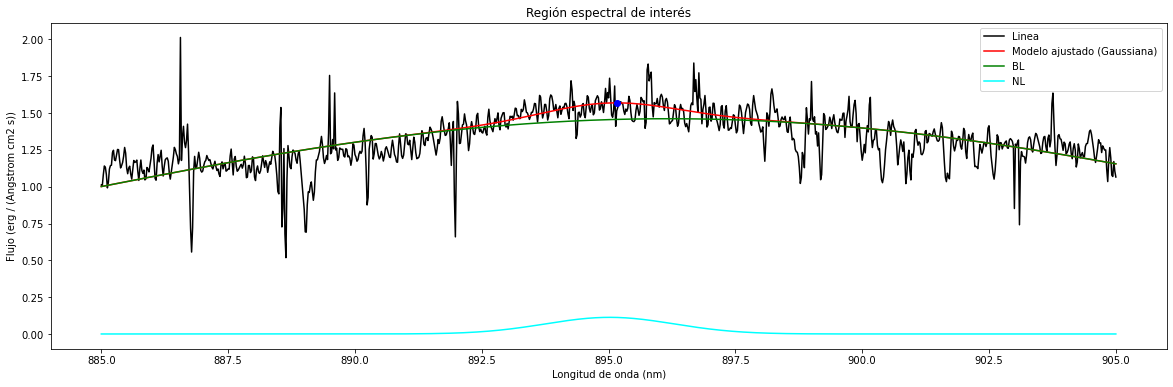

Parámetros óptimos: [  1.46183576 896.18624285  12.85434426]
Matriz de covarianza: [[ 4.25046216e-05 -1.01493471e-04 -1.09512040e-03]
 [-1.01493471e-04  1.10829782e-02  8.96089062e-03]
 [-1.09512040e-03  8.96089062e-03  5.82559809e-02]]
Incertidumbres de los parámetros: [0.00651956 0.10527572 0.24136276]
Parámetros óptimos: [1.12950472e-01 8.95022655e+02 1.26705038e+00]
Matriz de covarianza: [[ 2.17596717e-04  1.71260875e-08 -1.62729732e-03]
 [ 1.71260875e-08  3.65092363e-02 -1.92110418e-07]
 [-1.62729732e-03 -1.92110418e-07  3.65092355e-02]]
Incertidumbres de los parámetros: [0.01475116 0.1910739  0.1910739 ]


In [37]:
#linea 3
region_of_interest3 = SpectralRegion(885*u.nm, 905*u.nm)


mask3 = (wavelengths >= region_of_interest3.lower) & (wavelengths <= region_of_interest3.upper)


sub_spectrum3 = Spectrum1D(spectral_axis=wavelengths[mask3], flux=flux[mask3])

# Ajustar el modelo a los datos
parametros_optimosl3, matriz_covarianzal3 = curve_fit(modelo_gaussiano, wavelengths[mask3], flux[mask3], p0=[0.5, 895, 0.55])

ajuste1l3 = sub_spectrum3.flux-(modelo_gaussiano(wavelengths[mask3].value, *parametros_optimosl3)*u.erg/(u.Angstrom * u.cm * u.cm * u.s))

parametros_optimos3l2, matriz_covarianza3l2 = curve_fit(modelo_gaussiano, wavelengths[mask3], ajuste1l3.value, p0=[0.3, 895, 0.5])
ajuste_to3 = modelo_gaussiano(wavelengths[mask3].value, *parametros_optimosl3)+modelo_gaussiano(wavelengths[mask3].value, *parametros_optimos3l2)

peaks_ajustl3, _ = find_peaks(ajuste_to3, height=1)
print("El pico se encuentra en " + str(sub_spectrum3.spectral_axis[peaks_ajustl3])+ " con una intensidad cercana a los " +str(ajuste1l3[peaks_ajustl3]*u.erg/(u.Angstrom * u.cm * u.cm * u.s)))

# Calcular las incertidumbres de los parámetros ajustados
incertidumbres_parametrosl3 = np.sqrt(np.diag(matriz_covarianzal3))
incertidumbres_parametros3l2 = np.sqrt(np.diag(matriz_covarianza3l2))


plt.figure(figsize=(20,6))
plt.plot(sub_spectrum3.spectral_axis, sub_spectrum3.flux, color="black", label='Linea')
plt.plot(sub_spectrum3.spectral_axis, ajuste_to3, color='red', label='Modelo ajustado (Gaussiana)')
plt.plot(sub_spectrum3.spectral_axis, modelo_gaussiano(wavelengths[mask3].value, *parametros_optimosl3), color="green", label='BL')
plt.plot(sub_spectrum3.spectral_axis, modelo_gaussiano(wavelengths[mask3].value, *parametros_optimos3l2) , color="cyan", label='NL')
plt.plot(sub_spectrum3.spectral_axis[peaks_ajustl3], ajuste_to3[peaks_ajustl3], 'bo')
plt.xlabel('Longitud de onda ({})'.format(sub_spectrum1.spectral_axis.unit))
plt.ylabel('Flujo ({})'.format(sub_spectrum1.flux.unit))
plt.legend()
plt.title('Región espectral de interés')
plt.show()

print("Parámetros óptimos:", parametros_optimosl3)
print("Matriz de covarianza:", matriz_covarianzal3)
print("Incertidumbres de los parámetros:", incertidumbres_parametrosl3)
print("Parámetros óptimos:", parametros_optimos3l2)
print("Matriz de covarianza:", matriz_covarianza3l2)
print("Incertidumbres de los parámetros:", incertidumbres_parametros3l2)

El pico se encuentra en [978.54] nm con una intensidad cercana a los [2.22808309] erg / (Angstrom cm2 s)


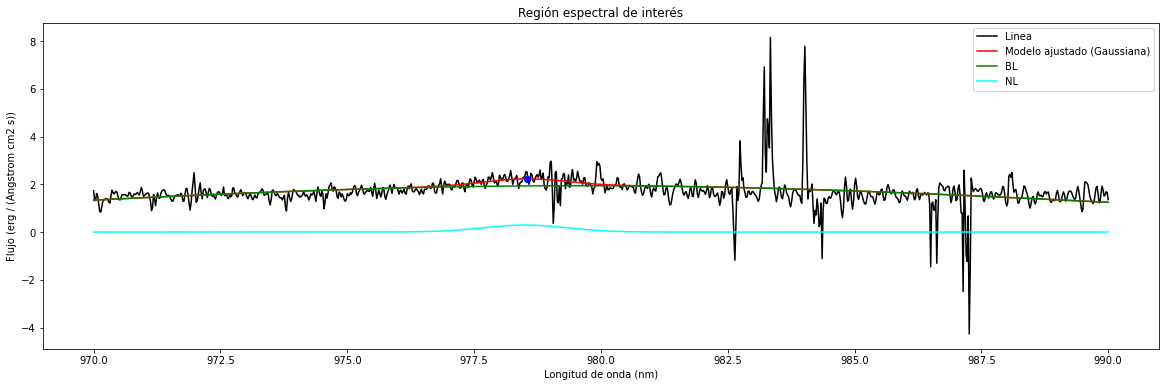

Parámetros óptimos: [  1.94202027 979.55527858  11.08785179]
Matriz de covarianza: [[ 0.0009906   0.00049455 -0.01277241]
 [ 0.00049455  0.07691857 -0.02094455]
 [-0.01277241 -0.02094455  0.33659341]]
Incertidumbres de los parámetros: [0.03147375 0.27734197 0.58016671]
Parámetros óptimos: [ 2.94567621e-01  9.78497727e+02 -8.31481009e-01]
Matriz de covarianza: [[7.91959568e-03 2.61341352e-07 1.49084663e-02]
 [2.61341352e-07 8.41945877e-02 7.37941674e-07]
 [1.49084663e-02 7.37941674e-07 8.41945871e-02]]
Incertidumbres de los parámetros: [0.08899211 0.29016304 0.29016304]


In [38]:
#linea 4
region_of_interest4 = SpectralRegion(970*u.nm, 990*u.nm)


mask4 = (wavelengths >= region_of_interest4.lower) & (wavelengths <= region_of_interest4.upper)


sub_spectrum4 = Spectrum1D(spectral_axis=wavelengths[mask4], flux=flux[mask4])


# Ajustar el modelo a los datos
parametros_optimosl4, matriz_covarianzal4 = curve_fit(modelo_gaussiano, wavelengths[mask4], flux[mask4], p0=[1.5, 978, 0.05])


ajuste1l4 = sub_spectrum4.flux-modelo_gaussiano(wavelengths[mask4].value, *parametros_optimosl4)*u.erg/(u.Angstrom * u.cm * u.cm * u.s)

parametros_optimos2l4, matriz_covarianza2l4 = curve_fit(modelo_gaussiano, wavelengths[mask4], ajuste1l4.value, p0=[0.1, 978, 5])
ajuste_tol4 = modelo_gaussiano(wavelengths[mask4].value, *parametros_optimosl4)+modelo_gaussiano(wavelengths[mask4].value, *parametros_optimos2l4)

peaks_ajustl4, _ = find_peaks(ajuste_tol4, height=1)
print("El pico se encuentra en " + str(sub_spectrum4.spectral_axis[peaks_ajustl4])+ " con una intensidad cercana a los " +str(ajuste_tol4[peaks_ajustl4]*u.erg/(u.Angstrom * u.cm * u.cm * u.s)))

# Calcular las incertidumbres de los parámetros ajustados
incertidumbres_parametrosl4 = np.sqrt(np.diag(matriz_covarianzal4))
incertidumbres_parametros2l4 = np.sqrt(np.diag(matriz_covarianza2l4))

plt.figure(figsize=(20,6))
plt.plot(sub_spectrum4.spectral_axis, sub_spectrum4.flux, color="black", label='Linea')
plt.plot(sub_spectrum4.spectral_axis, ajuste_tol4, color='red', label='Modelo ajustado (Gaussiana)')
plt.plot(sub_spectrum4.spectral_axis, modelo_gaussiano(wavelengths[mask4].value, *parametros_optimosl4), color="green", label='BL')
plt.plot(sub_spectrum4.spectral_axis, modelo_gaussiano(wavelengths[mask4].value, *parametros_optimos2l4) , color="cyan", label='NL')
plt.plot(sub_spectrum4.spectral_axis[peaks_ajustl4], ajuste_tol4[peaks_ajustl4], 'bo')
plt.xlabel('Longitud de onda ({})'.format(sub_spectrum1.spectral_axis.unit))
plt.ylabel('Flujo ({})'.format(sub_spectrum1.flux.unit))
plt.legend()
plt.title('Región espectral de interés')
plt.show()

print("Parámetros óptimos:", parametros_optimosl4)
print("Matriz de covarianza:", matriz_covarianzal4)
print("Incertidumbres de los parámetros:", incertidumbres_parametrosl4)
print("Parámetros óptimos:", parametros_optimos2l4)
print("Matriz de covarianza:", matriz_covarianza2l4)
print("Incertidumbres de los parámetros:", incertidumbres_parametros2l4)

In [ ]:
flux = flux_nom *u.erg/(u.Angstrom * u.cm * u.cm * u.s)
spectrum = Spectrum1D(spectral_axis=wavelengths, flux=flux)

region_of_interest1 = SpectralRegion(600*u.nm, 650*u.nm)


mask1 = (wavelengths >= region_of_interest1.lower) & (wavelengths <= region_of_interest1.upper)


sub_spectrum1 = Spectrum1D(spectral_axis=wavelengths[mask1], flux=flux[mask1])



# Ajustar el modelo a los datos
parametros_optimos, matriz_covarianza = curve_fit(modelo_gaussiano, wavelengths[mask1], flux[mask1], p0=[10, 600, 0.05])


ajuste1 = sub_spectrum1.flux-modelo_gaussiano(wavelengths[mask1].value, *parametros_optimos)*u.erg/(u.Angstrom * u.cm * u.cm * u.s)

parametros_optimos2, matriz_covarianza2 = curve_fit(modelo_gaussiano, wavelengths[mask1], ajuste1.value, p0=[3, 620, 5])
ajuste_to = modelo_gaussiano(wavelengths[mask1].value, *parametros_optimos)+modelo_gaussiano(wavelengths[mask1].value, *parametros_optimos2)

peaks_ajust, _ = find_peaks(ajuste_to, height=2.2)
print("El pico se encuentra en " + str(sub_spectrum1.spectral_axis[peaks_ajust])+ " con una intensidad cercana a los " +str(ajuste_to[peaks_ajust]*u.erg/(u.Angstrom * u.cm * u.cm * u.s)))

# Calcular las incertidumbres de los parámetros ajustados
incertidumbres_parametros = np.sqrt(np.diag(matriz_covarianza))
incertidumbres_parametros2 = np.sqrt(np.diag(matriz_covarianza2))


plt.figure(figsize=(20,6))
plt.plot(sub_spectrum1.spectral_axis, sub_spectrum1.flux, color="black", label='Linea')
plt.plot(sub_spectrum1.spectral_axis, ajuste_to, color='red', label='Modelo ajustado (Gaussiana)')
plt.plot(sub_spectrum1.spectral_axis, modelo_gaussiano(wavelengths[mask1].value, *parametros_optimos), color="green", label='BL')
plt.plot(sub_spectrum1.spectral_axis, modelo_gaussiano(wavelengths[mask1].value, *parametros_optimos2), color="cyan", label='NL')
plt.plot(sub_spectrum1.spectral_axis[peaks_ajust], ajuste_to[peaks_ajust], 'bo')
plt.xlabel('Longitud de onda ({})'.format(sub_spectrum1.spectral_axis.unit))
plt.ylabel('Flujo ({})'.format(sub_spectrum1.flux.unit))
plt.legend()
plt.title('Región espectral de interés')
plt.show()

print("Parámetros óptimos:", parametros_optimos)
print("Matriz de covarianza:", matriz_covarianza)
print("Incertidumbres de los parámetros:", incertidumbres_parametros)
print("Parámetros óptimos:", parametros_optimos2)
print("Matriz de covarianza:", matriz_covarianza2)
print("Incertidumbres de los parámetros:", incertidumbres_parametros2)

El pico se encuentra en [667.2] nm con una intensidad cercana a los [1.11611301] erg2 / (Angstrom2 cm4 s2)


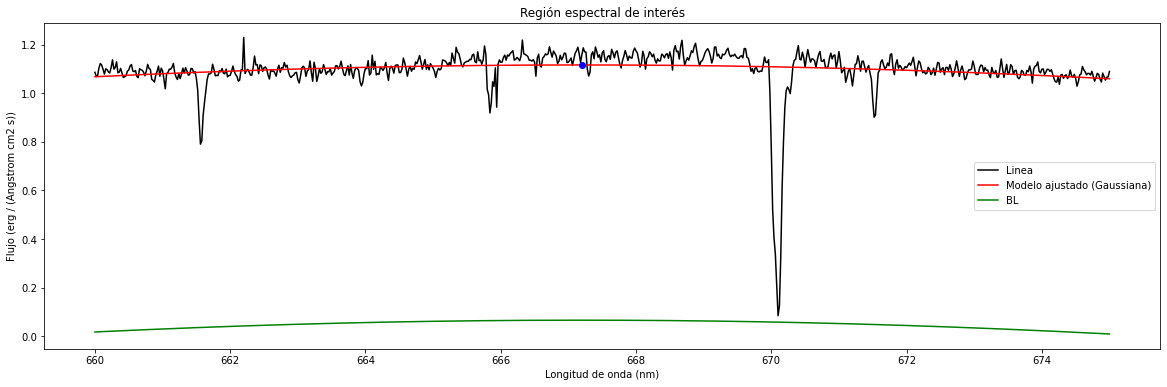

Parámetros óptimos: [  1.11611301 667.19850106  24.1531853 ]
Matriz de covarianza: [[ 2.67875744e-05  1.47325852e-04 -1.00895765e-02]
 [ 1.47325852e-04  1.85482692e-01 -1.69881475e-01]
 [-1.00895765e-02 -1.69881475e-01  6.98545748e+00]]
Incertidumbres de los parámetros: [0.00517567 0.43067702 2.6430016 ]


In [13]:
#linea 2
region_of_interest2 = SpectralRegion(660*u.nm, 675*u.nm)


mask2 = (wavelengths >= region_of_interest2.lower) & (wavelengths <= region_of_interest2.upper)


sub_spectrum2 = Spectrum1D(spectral_axis=wavelengths[mask2], flux=flux[mask2])

# Ajustar el modelo a los datos
parametros_optimosl2, matriz_covarianzal2 = curve_fit(modelo_gaussiano, wavelengths[mask2], flux[mask2], p0=[1, 667, 20])


ajuste1l2 = modelo_gaussiano(wavelengths[mask2].value, *parametros_optimosl2)*u.erg/(u.Angstrom * u.cm * u.cm * u.s)


peaks_ajustl2, _ = find_peaks(ajuste1l2, height=1)
print("El pico se encuentra en " + str(sub_spectrum2.spectral_axis[peaks_ajustl2])+ " con una intensidad cercana a los " +str(ajuste1l2[peaks_ajustl2]*u.erg/(u.Angstrom * u.cm * u.cm * u.s)))

# Calcular las incertidumbres de los parámetros ajustados
incertidumbres_parametrosl2 = np.sqrt(np.diag(matriz_covarianzal2))

plt.figure(figsize=(20,6))
plt.plot(sub_spectrum2.spectral_axis, sub_spectrum2.flux, color="black", label='Linea')
plt.plot(sub_spectrum2.spectral_axis, ajuste1l2, color='red', label='Modelo ajustado (Gaussiana)')
plt.plot(sub_spectrum2.spectral_axis, ajuste1l2-1.05*u.erg/(u.Angstrom * u.cm * u.cm * u.s), color="green", label='BL')
plt.plot(sub_spectrum2.spectral_axis[peaks_ajustl2], ajuste1l2[peaks_ajustl2], 'bo')
plt.xlabel('Longitud de onda ({})'.format(sub_spectrum1.spectral_axis.unit))
plt.ylabel('Flujo ({})'.format(sub_spectrum1.flux.unit))
plt.legend()
plt.title('Región espectral de interés')
plt.show()

print("Parámetros óptimos:", parametros_optimosl2)
print("Matriz de covarianza:", matriz_covarianzal2)
print("Incertidumbres de los parámetros:", incertidumbres_parametrosl2)

El pico se encuentra en [715.12] nm con una intensidad cercana a los [1.15124714] erg2 / (Angstrom2 cm4 s2)


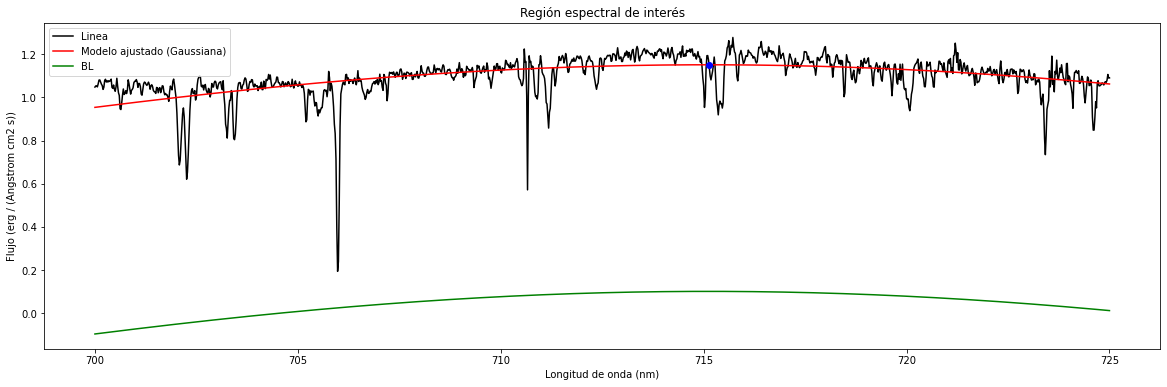

Parámetros óptimos: [  1.15124718 715.11327686  24.64424866]
Matriz de covarianza: [[ 1.11274692e-05 -1.64363085e-04 -1.51074415e-03]
 [-1.64363085e-04  5.00157858e-02  9.06910232e-02]
 [-1.51074415e-03  9.06910232e-02  4.59747481e-01]]
Incertidumbres de los parámetros: [0.00333579 0.22364209 0.67804681]


In [14]:
#linea 3
region_of_interest3 = SpectralRegion(700*u.nm, 725*u.nm)


mask3 = (wavelengths >= region_of_interest3.lower) & (wavelengths <= region_of_interest3.upper)


sub_spectrum3 = Spectrum1D(spectral_axis=wavelengths[mask3], flux=flux[mask3])

# Ajustar el modelo a los datos
parametros_optimosl3, matriz_covarianzal3 = curve_fit(modelo_gaussiano, wavelengths[mask3], flux[mask3], p0=[10, 720, 0.05])


ajuste1l3 = modelo_gaussiano(wavelengths[mask3].value, *parametros_optimosl3)*u.erg/(u.Angstrom * u.cm * u.cm * u.s)


peaks_ajustl3, _ = find_peaks(ajuste1l3, height=1)
print("El pico se encuentra en " + str(sub_spectrum3.spectral_axis[peaks_ajustl3])+ " con una intensidad cercana a los " +str(ajuste1l3[peaks_ajustl3]*u.erg/(u.Angstrom * u.cm * u.cm * u.s)))

# Calcular las incertidumbres de los parámetros ajustados
incertidumbres_parametrosl3 = np.sqrt(np.diag(matriz_covarianzal3))

plt.figure(figsize=(20,6))
plt.plot(sub_spectrum3.spectral_axis, sub_spectrum3.flux, color="black", label='Linea')
plt.plot(sub_spectrum3.spectral_axis, ajuste1l3, color='red', label='Modelo ajustado (Gaussiana)')
plt.plot(sub_spectrum3.spectral_axis, ajuste1l3-1.05*u.erg/(u.Angstrom * u.cm * u.cm * u.s), color="green", label='BL')
plt.plot(sub_spectrum3.spectral_axis[peaks_ajustl3], ajuste1l3[peaks_ajustl3], 'bo')
plt.xlabel('Longitud de onda ({})'.format(sub_spectrum1.spectral_axis.unit))
plt.ylabel('Flujo ({})'.format(sub_spectrum1.flux.unit))
plt.legend()
plt.title('Región espectral de interés')
plt.show()

print("Parámetros óptimos:", parametros_optimosl3)
print("Matriz de covarianza:", matriz_covarianzal3)
print("Incertidumbres de los parámetros:", incertidumbres_parametrosl3)


El pico se encuentra en [790.04] nm con una intensidad cercana a los [1.85757472] erg / (Angstrom cm2 s)


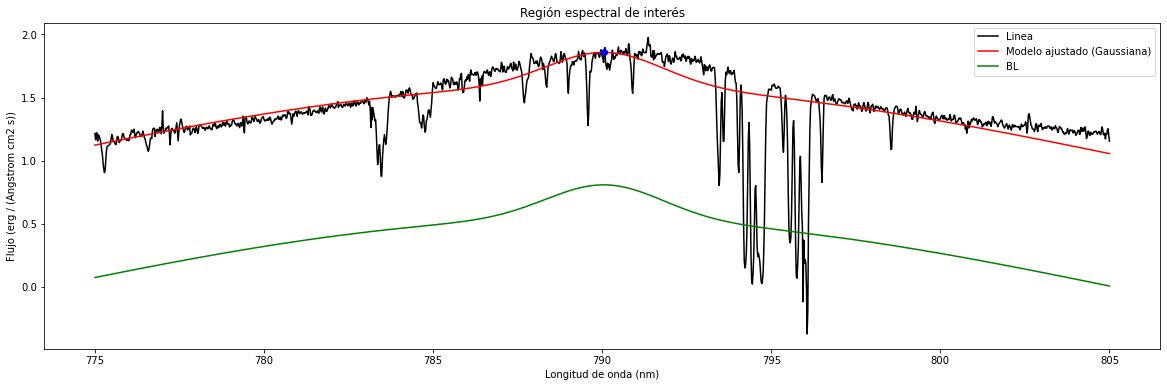

Parámetros óptimos: [  1.58627769 789.38076595  17.29851826]
Matriz de covarianza: [[ 1.23908326e-04  1.15400248e-04 -3.27804024e-03]
 [ 1.15400248e-04  3.69676891e-02 -9.96340441e-03]
 [-3.27804024e-03 -9.96340441e-03  1.75554685e-01]]
Incertidumbres de los parámetros: [0.01113141 0.19226983 0.41899246]
Parámetros óptimos: [2.72512175e-01 7.90076640e+02 1.69481473e+00]
Matriz de covarianza: [[ 6.72371462e-04  1.93658118e-08 -2.78775326e-03]
 [ 1.93658118e-08  3.46753341e-02 -1.20438659e-07]
 [-2.78775326e-03 -1.20438659e-07  3.46753341e-02]]
Incertidumbres de los parámetros: [0.02593013 0.18621314 0.18621314]


In [15]:
#linea 4
region_of_interest4 = SpectralRegion(775*u.nm, 805*u.nm)


mask4 = (wavelengths >= region_of_interest4.lower) & (wavelengths <= region_of_interest4.upper)


sub_spectrum4 = Spectrum1D(spectral_axis=wavelengths[mask4], flux=flux[mask4])


# Ajustar el modelo a los datos
parametros_optimosl4, matriz_covarianzal4 = curve_fit(modelo_gaussiano, wavelengths[mask4], flux[mask4], p0=[1.5, 790, 0.05])


ajuste1l4 = sub_spectrum4.flux-modelo_gaussiano(wavelengths[mask4].value, *parametros_optimosl4)*u.erg/(u.Angstrom * u.cm * u.cm * u.s)

parametros_optimos2l4, matriz_covarianza2l4 = curve_fit(modelo_gaussiano, wavelengths[mask4], ajuste1l4.value, p0=[0.1, 790, 5])
ajuste_tol4 = modelo_gaussiano(wavelengths[mask4].value, *parametros_optimosl4)+modelo_gaussiano(wavelengths[mask4].value, *parametros_optimos2l4)

peaks_ajustl4, _ = find_peaks(ajuste_tol4, height=1)
print("El pico se encuentra en " + str(sub_spectrum4.spectral_axis[peaks_ajustl4])+ " con una intensidad cercana a los " +str(ajuste_tol4[peaks_ajustl4]*u.erg/(u.Angstrom * u.cm * u.cm * u.s)))

# Calcular las incertidumbres de los parámetros ajustados
incertidumbres_parametrosl4 = np.sqrt(np.diag(matriz_covarianzal4))
incertidumbres_parametros2l4 = np.sqrt(np.diag(matriz_covarianza2l4))

plt.figure(figsize=(20,6))
plt.plot(sub_spectrum4.spectral_axis, sub_spectrum4.flux, color="black", label='Linea')
plt.plot(sub_spectrum4.spectral_axis, ajuste_tol4, color='red', label='Modelo ajustado (Gaussiana)')
plt.plot(sub_spectrum4.spectral_axis, (modelo_gaussiano(wavelengths[mask4].value, *parametros_optimosl4)+modelo_gaussiano(wavelengths[mask4].value, *parametros_optimos2l4))-1.05, color="green", label='BL')
#plt.plot(sub_spectrum4.spectral_axis, modelo_gaussiano(wavelengths[mask4].value, *parametros_optimos2l4), color="cyan", label='NL')
plt.plot(sub_spectrum4.spectral_axis[peaks_ajustl4], ajuste_tol4[peaks_ajustl4], 'bo')
plt.xlabel('Longitud de onda ({})'.format(sub_spectrum1.spectral_axis.unit))
plt.ylabel('Flujo ({})'.format(sub_spectrum1.flux.unit))
plt.legend()
plt.title('Región espectral de interés')
plt.show()

print("Parámetros óptimos:", parametros_optimosl4)
print("Matriz de covarianza:", matriz_covarianzal4)
print("Incertidumbres de los parámetros:", incertidumbres_parametrosl4)
print("Parámetros óptimos:", parametros_optimos2l4)
print("Matriz de covarianza:", matriz_covarianza2l4)
print("Incertidumbres de los parámetros:", incertidumbres_parametros2l4)